In [1]:
#| default_exp analysis

# EVCI analysis

> **API**: The utilization scores for each site are computed here.

In [1]:
#|hide
from nbdev.showdoc import *

## Import libraries

In [2]:
#|export

import numpy as np
import pandas as pd
import geopandas as gpd

import shapely

import os
from tqdm import tqdm

import matplotlib.pyplot as plt

from scipy.cluster.vq import kmeans2, whiten
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from evci_tool.config import *
from evci_tool.model import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
#|export

def run_episode(m,s,t,g,ui_inputs,s_df,txt,OUTPUT_PATH,corridor):
    "This function runs a full episode of analysis on a set of sites."
    
    print('\n' + txt.capitalize() + ' Analysis')
    print('________________\n')
    total = s_df.shape[0]
    
    #s_df = s_df[s_df['year 1'] == 1]
    #s_df = s_df.reset_index(drop=True)
    
    Nc = s_df.shape[0]
    print(f'Number of sites: {Nc}/{total}')

    #@title Compute scores

    backoff_factor = ui_inputs['backoff_factor']

    u_df = run_analysis(m,s,t,g,ui_inputs,s_df,backoff_factor=backoff_factor)

    print(f'Total capex charges = INR Cr {sum(u_df.capex)/1e7:.2f}')
    print(f'Total opex charges = INR Cr {sum(u_df.opex)/1e7:.2f}')
    print(f'Total Margin = INR Cr {sum(u_df.margin)/1e7:.2f}')        

    #@title Prepare data
    s_u_df = s_df.copy()

    s_u_df['utilization'] = u_df.utilization
    s_u_df['unserviced'] = u_df.unserviced
    s_u_df['capex'] = u_df.capex
    s_u_df['opex'] = u_df.opex
    s_u_df['margin'] = u_df.margin
    s_u_df['max vehicles'] = u_df['max vehicles']
    s_u_df['estimated vehicles'] = u_df['estimated vehicles']

    #@title Save initial analysis to Excel
    output_df = s_u_df.copy()
    output_df.drop('geometry', axis=1, inplace=True)
    
    # Save output dataframe as both xlsx and json
    output_df.to_excel(OUTPUT_PATH + '/' + txt + '_evci_analysis.xlsx')
    output_df.to_json(OUTPUT_PATH + '/' + txt + '_evci_analysis.json', orient='columns')
    
    return s_u_df

`Arguments`:

1. `m`: dataframe of model parameters (from model.xlsx)
2. `s`: dataframe of sites (from sites.xlsx)
3. `t`: dataframe of traffic profile (from traffic.xlsx)
4. `g`: dataframe of grid parameters (from grid.xlsx)
5. `ui_inputs`: json object of user selected inputs from the UI
6. `s_df`: pre-processed geopandas dataframe with each point stored as shapely point object
7. `txt`: a string that identifies the episode (e.g. initial, final, with_cluster etc)
8. `OUTPUT_PATH`: the directory path where the generated output files will be stored
9. `corridor`: a string that identifies the corridor being analyzed (e.g. chandigarh_leh)

`Returns`: 

A pandas dataframe: `s_u_df` is a dataframe with computed utilization values for each site.

In [4]:
#|export

def analyze_sites(corridor:str, ui_inputs):
    "The function analyzes sites specified as part of a corridor."

    #@title Read data from excel sheets
    model,site,traffic,grid, INPUT_PATH, OUTPUT_PATH = setup_and_read_data(corridor)
    
    #set variables for clustering etc from the UI
    cluster = ui_inputs['cluster']
    cluster_th = ui_inputs['cluster_th']
    plot_dendrogram = ui_inputs['plot_dendrogram']
    use_defaults = ui_inputs['use_defaults']

    #check if mandatory worksheets in xlsx files are available
    avail = data_availability_check(model,site,traffic,grid)
    assert len(avail) == 0, f"{avail} sheets missing from the xlsx. Please try again." 
    
    #check if any missingness
    missing = data_integrity_check(model,site,traffic,grid)
    #assert len(missing) > 0, f"{missing} sheets contain missing data." 

    #if missing values found, defaults shall be assumed for debug purposes. This is not for production version
    if use_defaults and len(missing) > 0:
        site['sites']['Traffic congestion'] = 1
        site['sites']['Year for Site recommendation'] = 1
        site['sites']['Hoarding/Kiosk (1 is yes & 0 is no)'] = 1
        site['sites']['Hoarding margin'] = 270000    
    
    #@title Read required data sheets only
    df = gpd.read_file(INPUT_PATH + '/shape_files/' + corridor + '.shp')

    data = site['sites']
    data['Name'] = data['Name']
    data['Latitude'] = pd.to_numeric(data['Latitude'])
    data['Longitude'] = pd.to_numeric(data['Longitude'])
    data['geometry'] = [shapely.geometry.Point(xy) for xy in 
                        zip(data['Longitude'], data['Latitude'])]

    data_df = {}

    data_df = gpd.GeoDataFrame(data, geometry=data['geometry'])

    s_df = pd.DataFrame(columns=['Name',
                                'Latitude', 'Longitude',
                                'Traffic congestion',
                                'year 1',
                                'kiosk hoarding',
                                'hoarding margin',
                                'geometry'])

    s_df = s_df.reset_index(drop=True)

    for i in range(data_df.shape[0]):
        s_df.loc[i] = [
           data_df.loc[i].Name, 
           data_df.loc[i].Latitude, 
           data_df.loc[i].Longitude, 
           data_df.loc[i]['Traffic congestion'],
           data_df.loc[i]['Year for Site recommendation'],
           data_df.loc[i]['Hoarding/Kiosk (1 is yes & 0 is no)'],
           data_df.loc[i]['Hoarding margin'],
           data_df.loc[i].geometry
        ] 

    s_u_df = run_episode(model,site,traffic,grid,ui_inputs,s_df,'initial',OUTPUT_PATH, corridor)

    #@title Threshold and cluster
    if cluster:
        #clustering_candidates = s_u_df[(s_u_df.utilization <= cluster_th) & (s_u_df['year 1'] == 1)]
        clustering_candidates = s_u_df[s_u_df.utilization <= cluster_th]
        print('candidates for clustering: ', clustering_candidates.shape[0])
        points = np.array((clustering_candidates.apply(lambda x: list([x['Latitude'], x['Longitude']]),axis=1)).tolist())
        Z = linkage (points, method='complete', metric='euclidean');
        if plot_dendrogram:
            plt.figure(figsize=(14,8))
            dendrogram(Z);
        max_d = 0.01
        clusters = fcluster(Z, t=max_d, criterion='distance')
        clustered_candidates = gpd.GeoDataFrame(clustering_candidates)
        #base = grid_df.plot(color='none', alpha=0.2, edgecolor='black', figsize=(8,8))
        #clustered_candidates.plot(ax=base, column=clusters, legend=True)

    #@title Build final list of sites
    confirmed_sites = s_u_df[s_u_df.utilization > cluster_th]
    print(f'confirmed sites with utilization > {int(cluster_th*100)}%: {confirmed_sites.shape[0]}')
    if cluster:
        val, ind = np.unique (clusters, return_index=True)
        clustered_sites = clustered_candidates.reset_index(drop=True)
        clustered_sites = clustered_sites.iloc[clustered_sites.index.isin(ind)]
        final_list_of_sites = pd.concat([confirmed_sites, clustered_sites], axis=0)
    else:
        final_list_of_sites = confirmed_sites.copy()

    if cluster:
        print('final list: ', final_list_of_sites.shape[0])
        s_df = final_list_of_sites.copy()
        s_df = s_df.reset_index(drop=True)
        
        s_u_df = run_episode(model,site,traffic,grid,ui_inputs,s_df,'clustered',OUTPUT_PATH, corridor)
    
    return s_u_df

`Arguments`:

1. `corridor`: a string that identifies the corridor being analyzed (e.g. chandigarh_leh)
2. `ui_inputs`: json object of user selected inputs from the UI

`Returns`:

`s_u_df`: a dataframe containing the list of sites and their utilization numbers.

In [6]:
# Inputs from UI
ui_inputs = { 
    "backoff_factor": 1,
    "M": ["3WS", "4WS", "4WF"],
    "years_of_analysis": [1,2],
    "capex_2W": 2500,
    "capex_3WS": 112000,
    "capex_4WS": 250000,
    "capex_4WF": 1500000,
    "hoarding cost": 900000,
    "kiosk_cost": 180000,
    "year1_conversion": 0.02,
    "year2_conversion": 0.05,
    "year3_conversion": 0.1,
    "holiday_percentage": 0.3,
    "fast_charging": 0.3,
    "slow_charging": 0.15,
    "cluster": False,
    "cluster_th": 0.2,
    "plot_dendrogram": False,
    "use_defaults": False    
}

s_u_df = analyze_sites('mumbai_goa', ui_inputs)


Initial Analysis
________________

Number of sites: 244/244


100%|██████████| 244/244 [00:39<00:00,  6.21it/s]


Total capex charges = INR Cr 45.68
Total opex charges = INR Cr 57.69
Total Margin = INR Cr 22.23
confirmed sites with utilization > 20%: 0


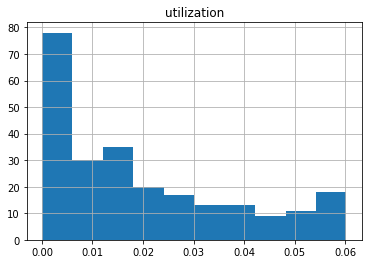

In [7]:
s_u_df.hist(column='utilization');

In [8]:
#s_u_df.hist(column='unserviced')

## With Clustering


Initial Analysis
________________

Number of sites: 244/244


100%|██████████| 244/244 [00:35<00:00,  6.79it/s]


Total capex charges = INR Cr 45.68
Total opex charges = INR Cr 57.69
Total Margin = INR Cr 22.23
candidates for clustering:  150
confirmed sites with utilization > 2%: 94
final list:  160

Clustered Analysis
________________

Number of sites: 160/160


100%|██████████| 160/160 [00:19<00:00,  8.06it/s]


Total capex charges = INR Cr 29.95
Total opex charges = INR Cr 38.78
Total Margin = INR Cr 14.66


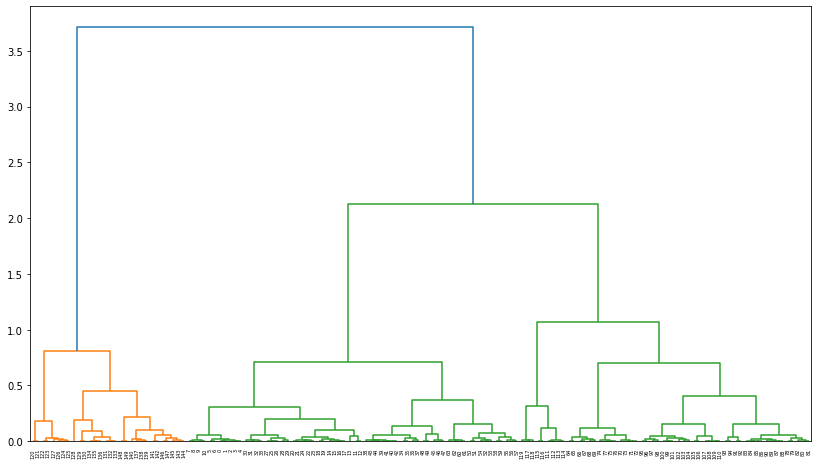

In [8]:
# Inputs from UI
ui_inputs = { 
    "backoff_factor": 1,
    "M": ["3WS", "4WS", "4WF"],
    "years_of_analysis": [1,2],
    "capex_2W": 2500,
    "capex_3WS": 112000,
    "capex_4WS": 250000,
    "capex_4WF": 1500000,
    "hoarding cost": 900000,
    "kiosk_cost": 180000,
    "year1_conversion": 0.02,
    "year2_conversion": 0.05,
    "year3_conversion": 0.1,
    "holiday_percentage": 0.3,
    "fast_charging": 0.3,
    "slow_charging": 0.15,
    "cluster": True,
    "cluster_th": 0.02,
    "plot_dendrogram": True,
    "use_defaults": False    
}
s_u_df = analyze_sites('mumbai_goa', ui_inputs)

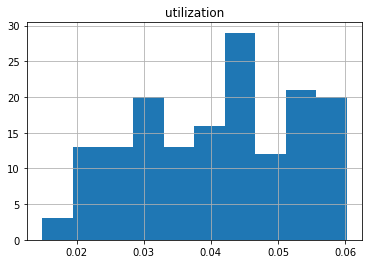

In [9]:
# after clustering
s_u_df.hist(column='utilization');